In [ ]:
import wget
!wget -nc https://www.dropbox.com/s/lkd0eklmi64m9xm/AirlineTweets.csv?dl=0

In [ ]:
import wget
wget.download('https://www.dropbox.com/s/lkd0eklmi64m9xm/AirlineTweets.csv?dl=0', 'Airline.csv')

In [1]:
# import required libraries
import pandas as pd
import numpy as np
import seaborn as sns

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('AirlineTweets.csv')

In [ ]:
df

In [ ]:
df.info()

In [4]:
df = df[['airline_sentiment','text']]

In [ ]:
df.head()

In [ ]:
df['airline_sentiment'].hist()

In [5]:
target_map = { 'positive': 1, 'negative': 0, 'neutral': 2}
df['target'] = df['airline_sentiment'].map(target_map)

In [ ]:
df.target.value_counts()

In [6]:
df1 = df[['text','target']]
df1.columns = ['sentence','label']
df1.to_csv('data.csv', index = False)

In [7]:
from datasets import load_dataset
raw_dataset=load_dataset('csv',data_files='data.csv')
raw_dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [ ]:
type(raw_dataset)

In [8]:
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)

In [ ]:
split

In [ ]:
# if we have multiple csv files
"""raw_dataset = load_dataset('csv', data_files = ['file1.csv','file2.csv'])
raw_dataset = load_dataset('csv', 
              data_files = { 'train': ['train1.csv','train2.csv'],
                             'test': 'test.csv'})"""

In [9]:
# Import AutoTokenizer and create tokenizer object
from transformers import AutoTokenizer
checkpoint = 'bert-base-cased'
tokernizer = AutoTokenizer.from_pretrained(checkpoint)

In [10]:
def tokenize_fn(batch):
  return tokernizer(batch['sentence'], truncation = True)

In [11]:
tokenized_dataset = split.map(tokenize_fn, batched = True)

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/4392 [00:00<?, ? examples/s]

In [12]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 3)
from torchinfo import summary
summary(model)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 590,592
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           2,307
Total params: 10

In [13]:
training_args = TrainingArguments(output_dir='training_dir',
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  num_train_epochs=3,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=64,
                                  )


In [14]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average = 'micro')
  return {'accuracy': acc, 'f1_score': f1}

In [15]:
trainer = Trainer(model,
                  training_args,
                  train_dataset = tokenized_dataset["train"],
                  eval_dataset = tokenized_dataset["test"],
                  tokenizer=tokernizer,
                  compute_metrics=compute_metrics)

In [16]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.522800,0.410251,0.833561,0.833561



KeyboardInterrupt



In [ ]:
!ls training_dir

In [17]:
from transformers import pipeline
saved_model = pipeline('text-classification',
                       model = 'training_dir/checkpoint-641')

In [18]:
split['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 4392
})

In [19]:
#to test all test data takes too much time so, run only below cell
predictions = saved_model(split['test']['sentence'])
predictions[:10]


KeyboardInterrupt



In [20]:
predictions = saved_model(split['test']['sentence'][:10])
predictions

[{'label': 'LABEL_1', 'score': 0.9337491393089294},
 {'label': 'LABEL_1', 'score': 0.8548933863639832},
 {'label': 'LABEL_0', 'score': 0.5674800872802734},
 {'label': 'LABEL_1', 'score': 0.7785561084747314},
 {'label': 'LABEL_2', 'score': 0.6610255837440491},
 {'label': 'LABEL_0', 'score': 0.9758533239364624},
 {'label': 'LABEL_2', 'score': 0.7241360545158386},
 {'label': 'LABEL_2', 'score': 0.8214108943939209},
 {'label': 'LABEL_1', 'score': 0.6659442186355591},
 {'label': 'LABEL_0', 'score': 0.9840677976608276}]

In [22]:
split['test']['label'][:10]

[1, 1, 2, 2, 0, 0, 2, 2, 1, 0]

In [24]:
result=[]
for x in predictions:
    if x['label']=='LABEL_1':
        result.append(1)
    elif x['label']=='LABEL_2':
        result.append(2)
    else:
        result.append(0)
result

[1, 1, 0, 1, 2, 0, 2, 2, 1, 0]

In [26]:
print("acc:",accuracy_score(split['test']['label'][:10], result))
print("f1:",f1_score(split['test']['label'][:10], result, average = 'macro'))

acc: 0.7
f1: 0.6984126984126985


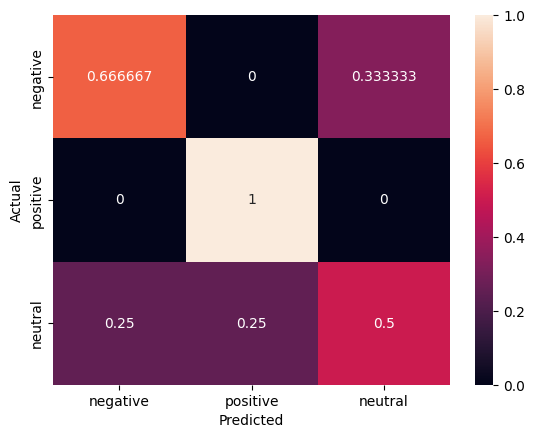

In [28]:
# create function for plotting confusion matrix
def plot_cm(cm):
  classes = ['negative','positive','neutral']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sns.heatmap(df_cm, annot = True, fmt='g')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

cm = confusion_matrix(split['test']['label'][:10],result, normalize = 'true')
plot_cm(cm)